In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense,Dropout
import tensorflow as tf
import random
from sklearn.model_selection import TimeSeriesSplit
import statsmodels.api as sm

import xgboost as xgb
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

import lightgbm
from sklearn.neural_network import MLPRegressor
from sklearn.svm import SVR
from lightgbm import early_stopping 

2024-11-09 19:01:22.359110: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-09 19:01:22.359241: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-09 19:01:22.545595: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/amirkabirdam/holiday.csv
/kaggle/input/amirkabirdam/dam12.csv
/kaggle/input/d/homaabedinzadeh/holidayname/holidayname.csv
/kaggle/input/d/homaabedinzadeh/futuredays/90days.csv
/kaggle/input/climate-indeices/ONI.xlsx
/kaggle/input/climate-indeices/ENSO.xlsx
/kaggle/input/climate-indeices/AMO.xlsx
/kaggle/input/climate-indeices/NAO.xlsx
/kaggle/input/climate-indeices/SOI.xlsx
/kaggle/input/feature-engineering/__results__.html
/kaggle/input/feature-engineering/__notebook__.ipynb
/kaggle/input/feature-engineering/__output__.json
/kaggle/input/feature-engineering/finaldatset.csv
/kaggle/input/feature-engineering/custom.css


In [4]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

In [5]:
df = pd.read_csv('/kaggle/input/feature-engineering/finaldatset.csv')


In [61]:
df.shape

(13772, 1662)

In [40]:
df.columns

Index(['BareshBarf_in', 'TotalAbBarfVBaran_in', 'MinDarajehararat_in',
       'MaxDarajehararat_in', 'Tabkhir_in', 'ShedatAftab_in', 'FesharJav_in',
       'SoratBad_in', 'JahatBad_in', 'VazeHava_in', 'DebiSeilabm3c',
       'DarajeHararat6_5', 'DarajeHararat12_5', 'DarajeHararat18_5',
       'DarajeHararatKhosk6_5', 'DarajeHararatKhosk12_5',
       'DarajeHararatKhosk18_5', 'DarajeHararatTar6_5', 'DarajeHararatTar12_5',
       'DarajeHararatTar18_5', 'NamNesbi6_5', 'NamNesbi12_5', 'NamNesbi18_5',
       'Total_in', 'Year', 'month', 'day_of_week', 'day_of_year', 'year_water',
       'DateRow'],
      dtype='object')

In [6]:
df.drop('DateRow', inplace=True , axis=1)

In [6]:
df=df[df['Year']>=2000]

In [7]:
horizon=-15

In [8]:
target = df['Total_in'].shift(horizon)

target.dropna(inplace=True)

In [65]:
df.head()

BareshBarf_in_shift_1  BareshBarf_in_shiftdiv_1  BareshBarf_in_shift_2  \
0                4.60517                       1.0                4.60517   
1                4.60517                       1.0                4.60517   
2                4.60517                       1.0                4.60517   
3                4.60517                       1.0                4.60517   
4                4.60517                       1.0                4.60517   

   BareshBarf_in_shiftdiv_2  BareshBarf_in_shift_7  BareshBarf_in_shiftdiv_7  \
0                       1.0                4.60517                       1.0   
1                       1.0                4.60517                       1.0   
2                       1.0                4.60517                       1.0   
3                       1.0                4.60517                       1.0   
4                       1.0                4.60517                       1.0   

   BareshBarf_in_shift_3  BareshBarf_in_shiftdiv_3  BareshBarf_in_shift_120  \
0                4.60517                       1.0                  4.60517   
1                4.60517                       1.0                  4.60517   
2                4.60517                       1.0                  4.60517   
3                4.60517                       1.0                  4.60517   
4                4.60517                       1.0                  4.60517   

   BareshBarf_in_shiftdiv_120  BareshBarf_in_shift_180  \
0                         1.0                  4.60517   
1                         1.0                  4.60517   
2                         1.0                  4.60517   
3                         1.0                  4.60517   
4                         1.0                  4.60517   

   BareshBarf_in_shiftdiv_180  BareshBarf_in_rollingmean_7  \
0                         1.0                      4.60517   
1                         1.0                      4.60517   
2                         1.0                      4.60517   
3                         1.0                      4.60517   
4                         1.0                      4.60517   

   BareshBarf_in_rollingstd_7  BareshBarf_in_rollingmin_7  \
0                         0.0                     4.60517   
1                         0.0                     4.60517   
2                         0.0                     4.60517   
3                         0.0                     4.60517   
4                         0.0                     4.60517   

   BareshBarf_in_rollingmax_7  BareshBarf_in_rollingsum_7  \
0                     4.60517                   32.236191   
1                     4.60517                   32.236191   
2                     4.60517                   32.236191   
3                     4.60517                   32.236191   
4                     4.60517                   32.236191   

   BareshBarf_in_div_rollingmean_7  BareshBarf_in_div_rollingstd_7  \
0                              1.0                             inf   
1                              1.0                             inf   
2                              1.0                             inf   
3                              1.0                             inf   
4                              1.0                             inf   

   BareshBarf_in_div_rollingmax_7  BareshBarf_in_rollingmean_30  \
0                             1.0                       4.60517   
1                             1.0                       4.60517   
2                             1.0                       4.60517   
3                             1.0                       4.60517   
4                             1.0                       4.60517   

   BareshBarf_in_rollingstd_30  BareshBarf_in_rollingmin_30  \
0                          0.0                      4.60517   
1                          0.0                      4.60517   
2                          0.0                      4.60517   
3                          0.0                      

In [9]:
y=target

x = df[:horizon]
#. drop(target,axis=1)


In [10]:
x.shape

(13757, 1665)

In [11]:
len(y)

13757

In [12]:
x.replace([np.inf, -np.inf], np.nan, inplace=True)
x.fillna(0, inplace=True)

/tmp/ipykernel_33/781971186.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.replace([np.inf, -np.inf], np.nan, inplace=True)
/tmp/ipykernel_33/781971186.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  x.fillna(0, inplace=True)


In [ ]:
x.shape

/tmp/ipykernel_33/4006950291.py:32: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  XGB_predictions = pd.concat([XGB_predictions, df_temp], ignore_index=True)


rmse: 0.4339064301234843
r2: 0.7632945059660383
mape: 0.24351341456109438
rmse: 0.44118110045150544
r2: 0.816017603026466
mape: 0.20940395919377366
rmse: 0.6800909195049677
r2: 0.5108600981477562
mape: 0.2694347549533666
rmse: 0.5701835448231223
r2: 0.7807187826467046
mape: 0.303956195371921
rmse: 0.6373848386076625
r2: 0.5358468603303993
mape: 0.2987602016241175
rmse: 0.6197408260428692
r2: 0.8020752524888625
mape: 0.2087514843674655
rmse: 0.2938006360045278
r2: 0.7980078662972971
mape: 0.21629945775611165
rmse: 0.4375997265986714
r2: 0.6938133798354558
mape: 0.2728042017947745
Weighted Average: 0.7299343388164308
rmsetest 0.5142360027696014
r2test: 0.7125792935923725
mapetest: 0.2528654587028281


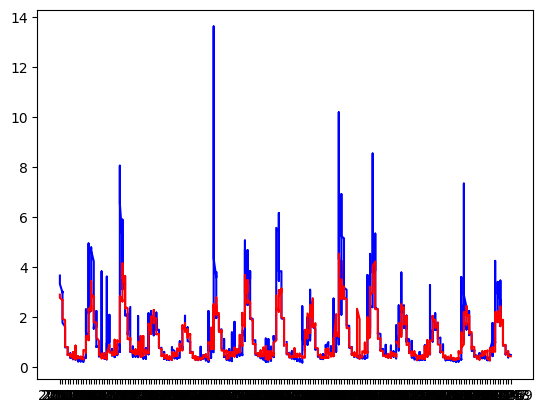

In [75]:
tscv = TimeSeriesSplit(n_splits = 20)
test_rmse = []
test_r2 = []
test_mape=[]
XGB_predictions = pd.DataFrame(columns=['predictXGB'])
epsilon = 1e-6

i=0
for train_index, test_index in tscv.split(x):
    i+=1
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    Y_train, Y_test = y.iloc[train_index], y.iloc[test_index]
    if i>=13:
        
        model = xgb.XGBRegressor(n_estimators=10000,early_stopping_rounds=10, learning_rate=0.07,  max_depth= 15 ,colsample_bytree= 0.85,  n_jobs=4)
        
        model.fit(X_train, Y_train,sample_weight=X_train['TotalAbBarfVBaran_in'], eval_set=[(X_test,Y_test)],verbose=False)

    # Predictions
        test_predict = model.predict(X_test)
        train_predict = model.predict(X_train)
        Y_test= (np.exp(Y_test)-100)/1000
        test_predict= (np.exp(test_predict)-100)/1000
        
        test_rmse.append ( np.sqrt(mean_squared_error(Y_test, test_predict)))
        test_mape.append (mean_absolute_percentage_error(Y_test, test_predict))
        test_r2.append (r2_score(Y_test, test_predict))
        
        df_temp = pd.DataFrame({'predictXGB': test_predict})

        # استفاده از pd.concat برای اضافه کردن پیش‌بینی‌ها به دیتافریم اصلی
        XGB_predictions = pd.concat([XGB_predictions, df_temp], ignore_index=True)
        

        
        print ('rmse:',np.sqrt(mean_squared_error(Y_test, test_predict)))
        print ('r2:', r2_score(Y_test, test_predict))
        print ('mape:', mean_absolute_percentage_error(Y_test, test_predict))

        plt.plot( X_test['Year'].astype(str) + X_test['month'].astype(str) ,Y_test, color='blue')
        plt.plot( X_test['Year'].astype(str) + X_test['month'].astype(str) ,test_predict, color='red')
weights=[1/(test_rmse+epsilon) for test_rmse in test_rmse]
weighted_sum = sum(w * r for w, r in zip(weights, test_r2))
total_weight = sum(weights)
weighted_average = weighted_sum / total_weight

print("Weighted Average:", weighted_average)

print("rmsetest",np.mean(test_rmse))
print ('r2test:',np.mean(test_r2) )
print ('mapetest:',np.mean(test_mape))




In [ ]:
XGB_predictions.shape

In [ ]:

imp = pd.DataFrame({'Importance':model.feature_importances_,'Feature':x.columns})
fe=imp.sort_values(by='Importance',ascending=False).head(50)
fe.head(50)

In [17]:
#LGB_predictions = pd.DataFrame(columns=['predictLGB'])
LGB_predictions

,predictLGB


0 656
657 1311
0 1311
1312 1966
0 1966
1967 2621
0 2621
2622 3276
0 3276
3277 3931
0 3931
3932 4586
0 4586
4587 5241
0 5241
5242 5896
0 5896
5897 6551
0 6551
6552 7206
0 7206
7207 7861
0 7861
7862 8516
0 8516
8517 9171
Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[79]	valid_0's l2: 0.0930644
rmse: 0.4291921107676153
r2: 0.768410093819918
mape: 0.23222930820778498
0 9171
9172 9826


/tmp/ipykernel_33/3905938330.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  LGB_predictions =pd.concat([LGB_predictions, df_temp] , ignore_index=True)
/tmp/ipykernel_33/3905938330.py:37: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  TestSet =pd.concat([TestSet, test_temp] , ignore_index=True)


Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[90]	valid_0's l2: 0.0503739
rmse: 0.4781406000692012
r2: 0.7839005219573096
mape: 0.1743741918854881
0 9826
9827 10481
Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[115]	valid_0's l2: 0.0657236
rmse: 0.6798650605373481
r2: 0.5111849320350446
mape: 0.2160336420314571
0 10481
10482 11136
Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[124]	valid_0's l2: 0.0672259
rmse: 0.49317842803585343
r2: 0.8359484952661851
mape: 0.22720425091165797
0 11136
11137 11791
Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[67]	valid_0's l2: 0.0772954
rmse: 0.5810381568115758
r2: 0.6142844550875498
mape: 0.24528718530124868
0 11791
11792 12446
Training until validation scores don't improve for 60 rounds
Early stopping, best iteration is:
[126]	valid_0's l2: 0.0507634

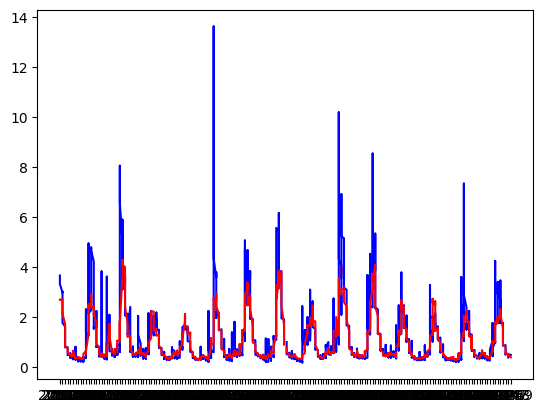

In [13]:
tscv = TimeSeriesSplit(n_splits = 20)
test_rmse = []
test_r2 = []
test_mape=[]
LGB_predictions = pd.DataFrame(columns=['predictLGB'])
TestSet=pd.DataFrame(columns=['Test'])
i=0
epsilon = 1e-6

for train_index, test_index in tscv.split(x):
    i+=1
    
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    Y_train, Y_test = y.iloc[train_index], y.iloc[test_index]
    print (train_index.min(),train_index.max())
    print (test_index.min(),test_index.max())
    if i>=13:
        lgb = lightgbm.LGBMRegressor( n_estimators=10000, num_leaves=40, learning_rate=0.04, colsample_bytree=0.9,verbose=0)

        lgb.fit(X_train, Y_train,sample_weight=X_train['TotalAbBarfVBaran_in'], eval_set=(X_test,Y_test),callbacks=([early_stopping(stopping_rounds=60)]))

        test_predict = lgb.predict(X_test, num_iteration=lgb.best_iteration_)
        
        Y_test= (np.exp(Y_test)-100)/1000
        test_predict= (np.exp(test_predict)-100)/1000
        
        test_rmse.append ( np.sqrt(mean_squared_error(Y_test, test_predict)))
        test_r2 .append ( r2_score(Y_test, test_predict))
        test_mape.append (mean_absolute_percentage_error(Y_test, test_predict))
  

        df_temp = pd.DataFrame({'predictLGB': test_predict})
        test_temp = pd.DataFrame({'Test': Y_test})

        # استفاده از pd.concat برای اضافه کردن پیش‌بینی‌ها به دیتافریم اصلی
        LGB_predictions =pd.concat([LGB_predictions, df_temp] , ignore_index=True)
        TestSet =pd.concat([TestSet, test_temp] , ignore_index=True)
       
        
        plt.plot( X_test['Year'].astype(str) + X_test['month'].astype(str) ,Y_test, color='blue')
        plt.plot( X_test['Year'].astype(str) + X_test['month'].astype(str) ,test_predict, color='red')
        print ('rmse:',np.sqrt(mean_squared_error(Y_test, test_predict)))
        print ('r2:', r2_score(Y_test, test_predict))
        print ('mape:', mean_absolute_percentage_error(Y_test, test_predict))
        #plt.show()
weights=[1/(test_rmse+epsilon) for test_rmse in test_rmse]
weighted_sum = sum(w * r for w, r in zip(weights, test_r2))
total_weight = sum(weights)
weighted_average = weighted_sum / total_weight

print("Weighted Average:", weighted_average)

print("rmsetest",np.mean(test_rmse))
print ('r2test:',np.mean(test_r2) )

print ('mapetest:',np.mean(test_mape))



In [ ]:
76.84/(76.84+ 75.55)

In [ ]:
 75.55/(76.84+ 75.55)

In [ ]:
final=pd.concat ([LGB_predictions ,XGB_predictions, TestSet], axis=1) 

In [ ]:
final['mean_column'] = ((final['predictLGB']*0.50) + (final['predictXGB']*0.49)) 

final.head()

In [ ]:
r2_score(final['Test'], final['mean_column'])


In [ ]:
imp = pd.DataFrame({'Importance':lgb.feature_importances_,'Feature':x.columns})
fe=imp.sort_values(by='Importance',ascending=False).head(50)
fe.head(50)

In [ ]:

df.dropna(inplace=True, axis=1)
df.shape
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

In [ ]:
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

In [ ]:
target=df['Total_in'].shift(horizon)
y=target

#x = scaled_df. drop(columns =[ target ],axis=1)#,'index'

In [ ]:
x=df.drop(columns=['Total_in'], axis=1)

In [ ]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(x)
scaled_df = pd.DataFrame(scaled_data, columns=x.columns)

In [ ]:
x=scaled_df[:horizon]

In [ ]:
x.shape

In [ ]:
y.dropna(inplace=True)

In [ ]:
y.shape

In [ ]:
tscv = TimeSeriesSplit(n_splits = 20)
test_rmse = []
test_r2 = []

test_mape=[]
MLP_predictions = pd.DataFrame(columns=['predictMLP'])
i=0
for train_index, test_index in tscv.split(x):
    i+=1
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    Y_train, Y_test = y.iloc[train_index], y.iloc[test_index]
    if i>=13:
        
        mlp = MLPRegressor(hidden_layer_sizes=( 512, 256), activation='relu', solver='adam', max_iter=300,learning_rate='constant', early_stopping=True,alpha=  0.0001 , batch_size=64)

        mlp.fit(X_train, Y_train )

        test_predict = mlp.predict(X_test)
        
        
        Y_test= (np.exp(Y_test)-100)/1000
        test_predict= (np.exp(test_predict)-100)/1000  
        
        test_rmse.append ( np.sqrt(mean_squared_error(Y_test, test_predict)))
        
        
        test_r2 .append ( r2_score(Y_test, test_predict))
        
        test_mape.append (mean_absolute_percentage_error(Y_test, test_predict))

        MLP_predictions = pd.DataFrame({'predictMLP': test_predict})
        
        
        plt.plot( X_test['Year'].astype(str) + X_test['month'].astype(str) ,Y_test, color='blue')
        plt.plot( X_test['Year'].astype(str) + X_test['month'].astype(str) ,test_predict, color='red')
        print ('rmse:',np.sqrt(mean_squared_error(Y_test, test_predict)))
        print ('r2:', r2_score(Y_test, test_predict))
        print ('mape:', mean_absolute_percentage_error(Y_test, test_predict))
        

print("rmsetest",np.mean(test_rmse))
print ('r2test:',np.mean(test_r2) )
print ('mapetest:',np.mean(test_mape))




In [ ]:
scv = TimeSeriesSplit(n_splits = 20)
test_rmse = []
train_rmse= []
test_r2 = []
train_r2=[]
test_mape=[]
predictSVR=[]
i=0
for train_index, test_index in tscv.split(x):
    i+=1
    X_train, X_test = x.iloc[train_index], x.iloc[test_index]
    Y_train, Y_test = y.iloc[train_index], y.iloc[test_index]
    if i>=13:
        
        svr = SVR(kernel='rbf', C=1.0, epsilon=0.001)

        # آموزش مدل
        svr.fit(X_train, Y_train)

        # پیش‌بینی
        test_predict = svr.predict(X_test)
        train_predict = svr.predict(X_train)
        predictSVR.append(test_predict)
        test_rmse.append ( np.sqrt(mean_squared_error(Y_test, test_predict)))
        train_rmse.append ( np.sqrt(mean_squared_error(Y_train, train_predict)))
        
        test_r2 .append ( r2_score(Y_test, test_predict))
        train_r2 .append ( r2_score(Y_train, train_predict))
        test_mape.append (mean_absolute_percentage_error(Y_test, test_predict))
        Y_test= (np.exp(Y_test)-100)/1000
        test_predict= (np.exp(test_predict)-100)/1000
        plt.plot( X_test['Year'].astype(str) + X_test['month'].astype(str) ,Y_test, color='blue')
        plt.plot( X_test['Year'].astype(str) + X_test['month'].astype(str) ,test_predict, color='red')
        print ('rmse:',np.sqrt(mean_squared_error(Y_test, test_predict)))
        print ('r2:', r2_score(Y_test, test_predict))
        print ('mape:', mean_absolute_percentage_error(Y_test, test_predict))
        #plt.show()
        
print("rmsetrain:",np.mean(train_rmse),"rmsetest",np.mean(test_rmse))
print ("r2train:",np.mean(train_r2),'r2test:',np.mean(test_r2) )
print ('mapetest:',np.mean(test_mape))

In [ ]:
df.shape

In [ ]:
df= df[df['Year']>=2000]

In [5]:
def high_correlation_columns(df, target_column, threshold =0.2):
    # محاسبه ماتریس همبستگی
    correlation_matrix = df.corr()

    # استخراج همبستگی ستون‌های دیگر با ستون هدف
    target_correlation = correlation_matrix[target_column].drop(target_column)

    # فیلتر کردن ستون‌هایی که همبستگی بالاتر از مقدار آستانه دارند
    high_corr_columns = target_correlation[abs(target_correlation) >= threshold].index.tolist()

    return high_corr_columns

In [6]:
result2 = high_correlation_columns(df, 'Total_in', threshold=0.5)
len (result2)

85

In [ ]:
print (result2)

In [7]:
target='Total_in'
df=df[result2 + [target]]

In [8]:
df.dropna(inplace=True, axis=1)

df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(0, inplace=True)

In [9]:
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(df)

In [18]:
def create_dataset_multistep(dataset, time_step=10, forecast_horizon=7, target_column = -8):
    X, y = [], []
    for i in range(len(dataset)-time_step-forecast_horizon):
        X.append(dataset[i:(i+time_step), :])
        y.append(dataset[i+time_step+forecast_horizon, target_column])
    return np.array(X), np.array(y)

time_step = 60
forecast_horizon = 15
target_column = -8
X, y = create_dataset_multistep(scaled_data, time_step, forecast_horizon,target_column)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

In [ ]:

tscv = TimeSeriesSplit(n_splits = 20)
test_rmse = []
test_r2 = []
i=0
for train_index, test_index in tscv.split(X):
    i+=1
    X_train, X_test = X[train_index], X[test_index]
    Y_train, Y_test = y[train_index], y[test_index]
    if i>=13:
        model = Sequential()
        model.add(LSTM(50, activation='relu', input_shape=(time_step, len(df.columns))))
        model.add(Dropout(0.3))
        model.add(Dense(1))
        model.compile(optimizer='adam', loss='mse')
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


        model.fit(X_train, Y_train, 
              epochs=50, 
              batch_size=32, 
              validation_data=(X_test, Y_test),
              callbacks=[early_stopping])
        
        test_predict = model.predict(X_test)

        test_predict = np.clip(test_predict, 0, 1)

        test_predict = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], test_predict), axis=1))[:, -1]

        orig_test_y = scaler.inverse_transform(np.concatenate((X_test[:, -1, :-1], Y_test.reshape(-1,1)), axis=1))[:, -1]
        
        orig_test_y= (np.exp(orig_test_y)-100)/1000
        test_predict= (np.exp(test_predict)-100)/1000
        print(f"Test RMSE: {np.sqrt(mean_squared_error(orig_test_y, test_predict))}")
        print(f" Test R2: {r2_score(orig_test_y, test_predict)}")
        
        test_rmse.append ( np.sqrt(mean_squared_error(orig_test_y, test_predict)))
        test_r2 .append ( r2_score(orig_test_y, test_predict))
    
print(f"Test RMSE: {np.mean(test_rmse)}")
print(f" Test R2: {np.mean(test_r2)}")
    
   

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 9s 36ms/step - loss: 0.0553 - val_loss: 0.0072
Epoch 2/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0074 - val_loss: 0.0074
Epoch 3/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.0066 - val_loss: 0.0057
Epoch 4/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0057 - val_loss: 0.0067
Epoch 5/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0053 - val_loss: 0.0056
Epoch 6/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0046 - val_loss: 0.0054
Epoch 7/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.0044 - val_loss: 0.0055
Epoch 8/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 37ms/step - loss: 0.0040 - val_loss: 0.0060
Epoch 9/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 36ms/step - loss: 0.0042 - val_loss: 0.0075
Epoch 10/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0045 - val_loss: 0.0059
Epoch 11/50
201/201 ━━━━━━━━━━━━━━━━━━━━ 7s 35ms/step - loss: 0.0039 - val_loss: 0.0054
20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step
T

/opt/conda/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0849 - val_loss: 0.0063
Epoch 2/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0077 - val_loss: 0.0059
Epoch 3/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0064 - val_loss: 0.0053
Epoch 4/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 8s 36ms/step - loss: 0.0055 - val_loss: 0.0053
Epoch 5/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0052 - val_loss: 0.0050
Epoch 6/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0051 - val_loss: 0.0050
Epoch 7/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 8s 34ms/step - loss: 0.0046 - val_loss: 0.0054
Epoch 8/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - loss: 0.0046 - val_loss: 0.0048
Epoch 9/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0044 - val_loss: 0.0054
Epoch 10/50
221/221 ━━━━━━━━━━━━━━━━━━━━ 8s 35ms/step - loss: 0.0041 - val_loss: 0.0053
Epoch 11/50
 95/221 ━━━━━━━━━━━━━━━━━━━━ 4s 32ms/step - loss: 0.0037